# Images and Filters

This notebook intends to show you the differences between the original and filtered images that can be computed to extract additional radiomic features (high-order texture features).

## Check Environment and Install required libraries to execute notebooks

The command to install a library is: ```!pip install <library_name> ```

We may choose a specific version by using ```!pip install <library_name>==<version>```

Example: ```!pip install SimpleITK==2.0.0```

In [2]:
!python -c "import SimpleITK" || pip install --upgrade --pre SimpleITK --find-links https://github.com/SimpleITK/SimpleITK/releases/tag/latest --progress-bar off -q
!python -c "import matplotlib" || pip install --progress-bar off -q matplotlib
!python -c "import pywt" || pip install --progress-bar off -q PyWavelets
!python -c "import gdown" || pip install --progress-bar off -q gdown
%matplotlib inline

### Download example data from https://github.com/rcuocolo/PROSTATEx_masks repository

In [3]:
!gdown --id 11SkIz9WFodGyScBOo_Up3j2LOu1YTK6w -q

--2024-05-09 03:00:46--  https://github.com/rcuocolo/PROSTATEx_masks/blob/master/Files/lesions/Images/T2/ProstateX-0010_t2_tse_tra_6.nii.gz
Resolving github.com (github.com)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘github.com’


In [4]:
#@title Import required libraries
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Read example T2-weighted prostate MRI corresponding to case ID ProstateX-0010 

We can use SimpleITK and matplotlib.pyplot to display some slices of the prostate MRI T2-weighted sequence.

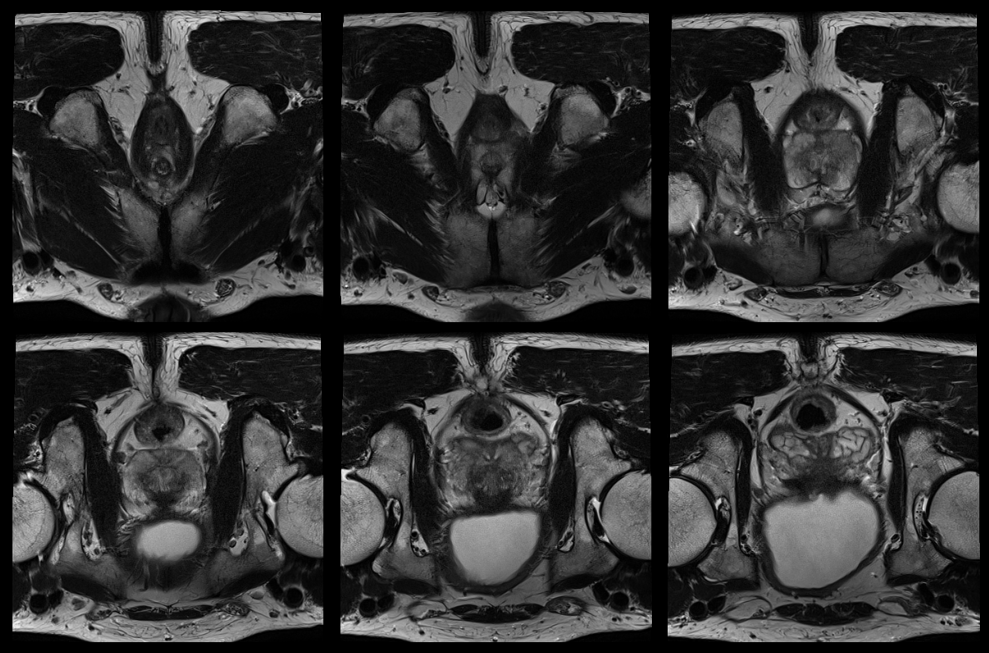

In [6]:
# The following line reads the prostate MRI image (3D volume) and assigns it to the variable image
image = sitk.ReadImage('ProstateX-0010_t2_tse_tra_6.nii.gz')

# select a couple of slices to display
fig, axes = plt.subplots (nrows = 2, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[0,2].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[1,0].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
axes[1,2].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=-15, w_pad=1)

## Create a copy of the prostate image in float 64-bits (double precision)

In order to not lose information, some operations need to be done in float or double precision. We will transform the voxel type of our image into 64-bits floating point (double precision).

In [7]:
# cast image voxel bit depth to 64-bits
image_float64 = sitk.Cast(image,sitk.sitkFloat64)

Create examples of:

* Laplacian of Gaussian with sigma of 1 mm
* Laplacian of Gaussian with sigma of 5 mm
* Exponential
* Logarithm
* Square
* Square-Root
* Gradient
* LBP2D
* Wavelet decompositions

In [8]:
image_log_sigma_1 = sitk.LaplacianRecursiveGaussian(image_float64, sigma=1)
image_log_sigma_5 = sitk.LaplacianRecursiveGaussian(image_float64, sigma=5)
image_exponential = sitk.Exp(sitk.Normalize(image_float64))
image_logartihm = sitk.Log(image_float64)
image_square = sitk.Square(image_float64)
image_sqrt = sitk.Sqrt(image_float64)
image_gradient = sitk.GradientMagnitude(image_float64, useImageSpacing=True)

# import local_binary_pattern from skimage library
from skimage.feature import local_binary_pattern
lbp_radius = 1
lbp_samples = 8
lbp_method = 'uniform'
lbp_axis = 0

# for local binary patterns we need the skimage and to use a numpy array instead of an sitk.Image and run local binary pattern on each slice
im_arr = sitk.GetArrayFromImage(image_float64)
im_arr = im_arr.swapaxes(0, lbp_axis)
for idx in range(im_arr.shape[0]):
    im_arr[idx, ...] = local_binary_pattern(im_arr[idx, ...], P=lbp_samples, R=lbp_radius, method=lbp_method)
im_arr = im_arr.swapaxes(0, lbp_axis)

# transform the local binary pattern output numpy array into an sitk.Image with the original spacing, origin, and direction
image_lpb2d = sitk.GetImageFromArray(im_arr)
image_lpb2d.CopyInformation(image_float64)

# import pywavelet libraries
import pywt
import pywt.data

# Load image
original = sitk.GetArrayFromImage(image_float64)[8,:,:]

# Wavelet transform of image, and plot approximation and details
titles = ['Wv-LL: Approximation', 'Wv-LH: Horizontal detail',
          'Wv-HL: Vertical detail', 'Wv-HH: Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2

/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


And now lets visualize them and compare them side by side with the original image.

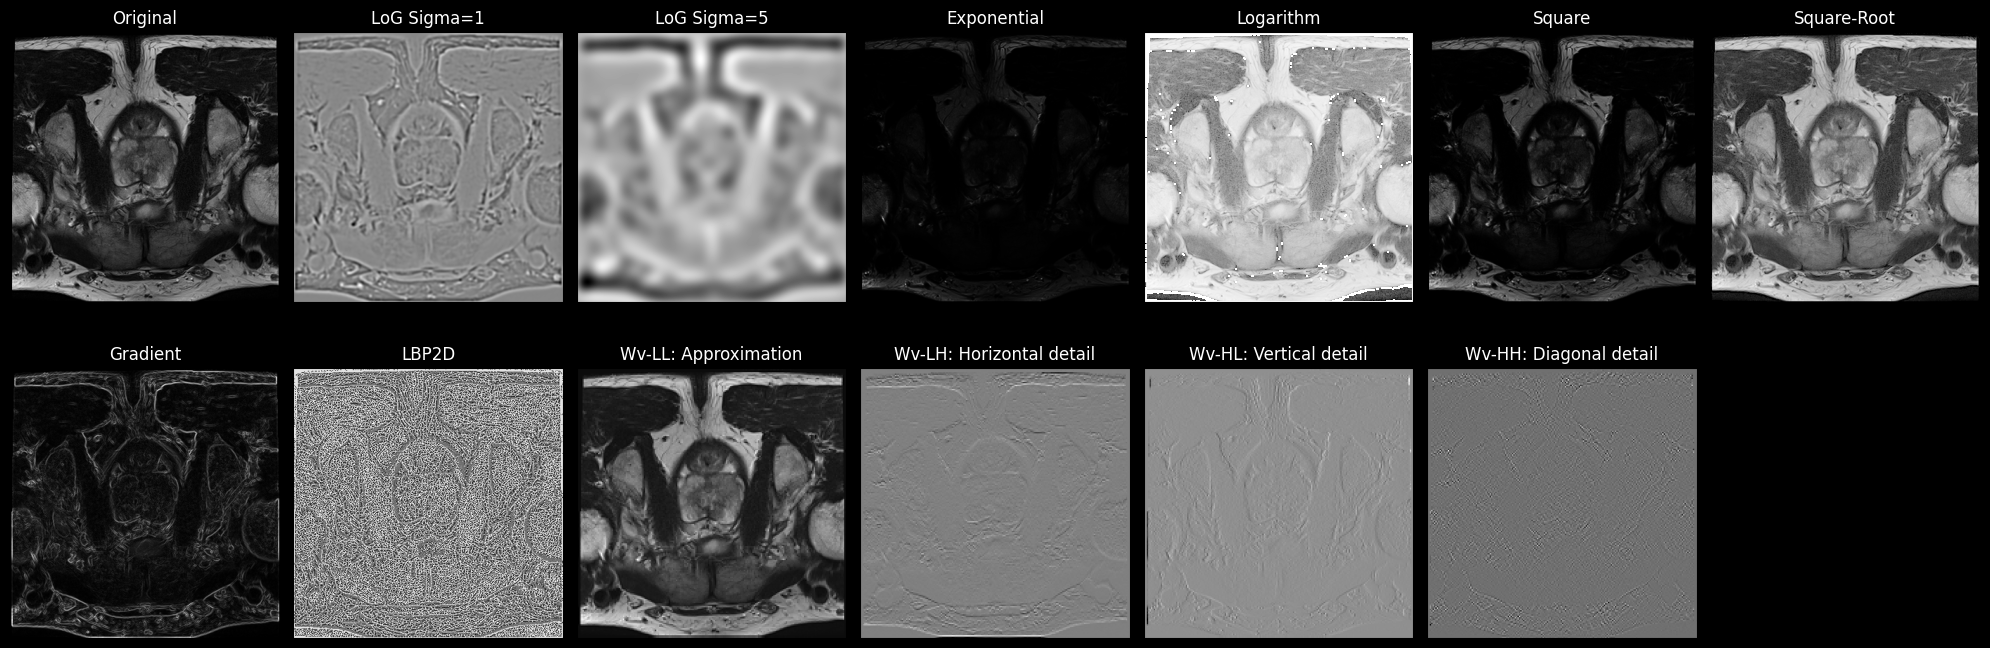

In [9]:
# select a couple of slices to display
fig, axes = plt.subplots (nrows = 2, ncols = 7, figsize = (20, 20))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image_float64)[8,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(image_log_sigma_1)[8,:,:], cmap='gray')
axes[0,2].imshow(sitk.GetArrayFromImage(image_log_sigma_5)[8,:,:], cmap='gray')
axes[0,3].imshow(sitk.GetArrayFromImage(image_exponential)[8,:,:], cmap='gray')
axes[0,4].imshow(sitk.GetArrayFromImage(image_logartihm)[8,:,:], cmap='gray')
axes[0,5].imshow(sitk.GetArrayFromImage(image_square)[8,:,:], cmap='gray')
axes[0,6].imshow(sitk.GetArrayFromImage(image_sqrt)[8,:,:], cmap='gray')



axes[1,0].imshow(sitk.GetArrayFromImage(image_gradient)[8,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(image_lpb2d)[8,:,:], cmap='gray')
axes[1,2].imshow(LL, cmap='gray')
axes[1,3].imshow(LH, cmap='gray')
axes[1,4].imshow(HL, cmap='gray')
axes[1,5].imshow(HH, cmap='gray')

axes[0,0].set_title('Original', color='w')
axes[0,1].set_title('LoG Sigma=1', color='w')
axes[0,2].set_title('LoG Sigma=5', color='w')
axes[0,3].set_title('Exponential', color='w')
axes[0,4].set_title('Logarithm', color='w')
axes[0,5].set_title('Square', color='w')
axes[0,6].set_title('Square-Root', color='w')


axes[1,0].set_title('Gradient', color='w')
axes[1,1].set_title('LBP2D', color='w')
axes[1,2].set_title(titles[0], color='w')
axes[1,3].set_title(titles[1], color='w')
axes[1,4].set_title(titles[2], color='w')
axes[1,5].set_title(titles[3], color='w')
fig.delaxes(axes[1][6])

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=-75, w_pad=1)